###Note on Dependencies

Be careful here with dependencies. I am not using spacy-transformers at this point, but the version of transformers needed for spacy-transformers to work is incompatible with the version needed for sentence-transformers to work. You can get around this by installing and uninstalling two different versions or running two different notebooks. Either way, you'll need to make sure you have a version of transformers compatible with what you're trying to run, and you need to make sure you've uninstalled the incompatible library.

To be clear, this list may not be exhaustive depending on your environment or what you specifically running. I have numpy and pandas but you may not. Also I don't think anything extraneous is here but mistakes happen. I'll clean this up later but consider this a starting point, not a guarantee of functionality.

In [ ]:
#!pip uninstall spacy-transformers
!pip install pdfplumber
!pip install nltk
!pip install plotly
!pip install bertopic
!pip install umap-learn
!pip install scikit-learn
!pip install sentence-transformers
!pip install transformers==4.44.2
!pip install spacy

##Getting The Text Data

I've chosen to use pdfplumber to get the text from a pdf, but the goal is simply to get the text data into a useable format. Other options include:



1.   Webscraping using Beautiful Soup
2.   Copy and Pasting Text (old school but works)
1.   Audio-to-Text Transcription (think earnings Calls)
2.   etc. (Expand) -- using Tesseract for OCR on scanned documents?

The point is we can work with a variety of formats, although there are some drawbacks such as inaccuracy in using transcription software compared to using an offically sanctioned, company provided transcription. The best technique will probably depend on the source, the company, and potentially the type of document. Either way, the goal is to get the text into a workable format. This is definitely an area we can expand, but no need to give ourselves a headache upfront. Makes more sense to start with something and build beyond that.

### *But which section precisely?*

A better question is how to focus on a particular section of the text. Here I've chosen to focus on the MD&A as a starting point, but this would obviously vary by document. Other areas of focus would include the footnotes. Right now I've done this fairly manually with the specific lines of text below, but could probably solve this with RegEx or some more graceful means. Ideally would want to be able to choose which section or sections to focus on without manually copying and pasting unique identifying text bits here, but this works for now.

Note that the text and the financials can come from different sections. Financial Statements are generally less text based while MD&A would have snippets of financial info that management chooses to highlight. Footnotes might have granular details that the main tables miss. Important to make sure we capture the right data, but want to avoid a scattershot approach of "here is everything" as well.





In [ ]:
# Import necessary libraries
import pdfplumber
import nltk
import plotly
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from transformers import pipeline
from collections import Counter
from bertopic import BERTopic
from umap import UMAP
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Step 1: Extract Text from PDF
with pdfplumber.open("MIST 10-Q.pdf") as pdf: # can change to other file names
    full_text = ""
    for page in pdf.pages:
        full_text += page.extract_text()

# Step 2: Isolate the MDA Section. Manual but it works for now
mda_start = full_text.find("Management’s Discussion and Analysis")
mda_end = full_text.find("The primary objective of our investment activities is to preserve principal and liquidity") # Need more graceful way. RegEx?
mda = full_text[mda_start:mda_end]

##Text Pre-processing

Next we want to get the text into a workable form. What I've done is removing stop words, which are words with limited semantic value. Note that this is a really basic approach below. Definitely could add more financially focused words here, as well as those focused solely on the industry at hand. Also note that we could tune some of these hyperparameters like chunk size. I've used lemmatization so we can focus on the core semantics of the words rather than getting bogged down on "approval" vs "approvals" but if "approve" vs "approved" turns out to be a relevant distinction this may be a point to revist.

Also worth noting that I've chosen to filter down to only the alpha characters here, NOT numeric. This should help for text analysis but makes NER more challenging. On the other hand, including numeric by doing isalnum rather than isalpha makes topic modeling harder. Can revist this assumption fairly easily and have included a commented-out option to adjust this later.

This is meant as a starting point to judge the size of the outstanding task, not to consider it solved. The section ends with a brief sanity check, but will need to revisit this part.

In [ ]:
# Step 3: Download NLTK tools and get stopwords (prebuilt and custom)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stop words and additional custom stop words
stop_words = set(stopwords.words('english'))
additional_stop_words = {"http", "form", "table", "2024"}
all_stop_words = stop_words.union(additional_stop_words)
lemmatizer = WordNetLemmatizer()

# Step 4: Preprocess the text
def preprocess_text(text, num_documents=138, token_first=True):

    if token_first:

        # Tokenize the entire document
        tokens = word_tokenize(text.lower())

        # Apply lemmatization and remove stop words
        preprocessed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in all_stop_words]
        #preprocessed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in all_stop_words]

        # Split the Preprocessed Tokens into Chunks
        chunk_size = len(preprocessed_tokens) // num_documents  # Determine the chunk size

        # Split into the desired number of documents
        processed_documents = [' '.join(preprocessed_tokens[i:i + chunk_size]) for i in range(0, len(preprocessed_tokens) - (len(preprocessed_tokens) % chunk_size), chunk_size)]

        # Handle any remaining tokens that don't fit into the chunks
        remainder = len(preprocessed_tokens) % chunk_size
        if remainder > 0:
            # Append the remaining tokens to the last document directly, ensuring no new document is created
            processed_documents[-1] += ' ' + ' '.join(preprocessed_tokens[-remainder:])

        # Ensure we only have the specified number of documents, without leftover tokens appeneded to final document
        # NOTE: This line shouldn't do anything and is more of a failsafe than a necessity
        processed_documents = processed_documents[:num_documents]

    else: # Split Text into Lines and Join into Blocks of Defined Chunk Size

        chunk_size = 10  # Define the size of text chunks
        lines = text.split('\n')
        documents = [' '.join(lines[i:i + chunk_size]) for i in range(0, len(lines), chunk_size)]

        # Tokenize and process each document chunk separately
        processed_documents = []
        for doc in documents:
            tokens = word_tokenize(doc.lower())
            processed_text = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in all_stop_words]
            processed_documents.append(' '.join(processed_text))

    return processed_documents

# # # Step 5: Don't forget to actually call the function!
processed_documents =preprocess_text(mda, num_documents=138, token_first=True)

#Check for empty or small documents
# # Not necessary to do, but a nice sanity check
min_size_threshold = 10
for index, doc in enumerate(processed_documents):
    doc_size = len(doc.split())
    if doc_size < min_size_threshold:
        print(f"Document {index} is below the size threshold with {doc_size} words.")
    elif doc_size == 0:
        print(f"Document {index} is empty.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Latent Dirichlet Allocation(LDA) Topic Modeling

LDA is topic modeling technique that aims to identify topics based on how frequently words occur together. This is different from BERTopic, coming next, which takes into account the semantic context of words. It doesn't name the topic specifically, but it does give groupings, which we can label using an additional model or manually. The key is to see how many topics are really necessary. The model can try to create 20 different topics (change the "6" to "21" in the range function and look at the output), but the end result will be highly repetitive in this case (and most others). On the other hand, choosing one or two topics will frequently miss important themes. Striking the right balance here is key. In addition, this is not a model that is designed specifically for financial data, so I would caution against using it for financial data. As such, I consider this a basic starting point, NOT  recommended model.

The main takeaways I see from the data are "clinical" and "financial" with other topics overlapping with these two to various degrees.

In [ ]:
# initialize vector
vectorizer = CountVectorizer(max_df=0.95, min_df=1)
doc_term_matrix = vectorizer.fit_transform(processed_documents)

# Function to Display LDA Topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Run LDA Topic Modeling
for n_topics in range(2, 6):  # Change the range to explore different topic numbers. Focused just on 5 for now since that looked promising.
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)
    print(f"Displaying {n_topics} topics:")
    display_topics(lda, vectorizer.get_feature_names_out(), 10)
    print("------------")

Displaying 2 topics:
Topic 1:
share june expense ended development million month cost note etripamil
Topic 2:
plan statement option financial period company etripamil annual patient rate
------------
Displaying 3 topics:
Topic 1:
expense development etripamil patient clinical million research cost product month
Topic 2:
financial statement annual company accounting etripamil asu drug december disclosure
Topic 3:
share plan option june note company statement common period purchase
------------
Displaying 4 topics:
Topic 1:
product etripamil june million clinical month expense ended development trial
Topic 2:
financial statement company annual accounting asu item december consolidated tax
Topic 3:
share plan option note june period common company purchase statement
Topic 4:
expense patient development etripamil million cost net research loss rate
------------
Displaying 5 topics:
Topic 1:
etripamil product development clinical trial revenue candidate expense future may
Topic 2:
financial

###BERTopic Modeling
BERTopic is a topic modeling technique used to uncover and identify themes or topics within a document or series of documents. It helps us determine the main areas of discussion and identify recurring themes.

Specifically, BERTopic leverages transformer-based embeddings and clustering algorithms to provide a more context-aware understanding of topics compared to traditional methods like Latent Dirichlet Allocation (LDA). Traditional methods often rely on simple word counts without considering the semantic meaning and context, which can limit their effectiveness. In contrast, BERTopic uses pretrained transformer models to capture nuanced relationships between words, which is particularly valuable for domain-specific language.

In our model, UMAP (Uniform Manifold Approximation and Projection) is used to reduce dimensionality. The parameters for UMAP and BERTopic are adjusted through trial and error. It's also worth noting that BERTopic involves stochastic processes, so results can vary with different seeds. Using a seed like random_state=4 helps ensure reproducibility, but different seeds can sometimes result in less meaningful topics or errors during visualization, necessitating further refinement.

It's important to note that BERTopic is a general-purpose model and not specifically designed for financial texts. While FinBERT is a financial domain-specific model, it is primarily used for sentiment analysis rather than topic modeling. We will explore FinBERT later in our analysis for sentiment-focused tasks.

###*To-Do List*
Moving forward, we can use BERTopic to identify which themes are discussed in a document and which ones are missing. For example, we could compare topics that consistently appear in this document with those in previous 10-Q or 10-K filings or earnings call transcripts. If an earnings call transcript shows that analysts are keenly focused on a specific issue, but the MD&A (Management Discussion and Analysis) section of a report makes no mention of it or downplays it, that could be a red flag. We should explore how to incorporate this comparison effectively.

Additionally, it may be worth considering more financially specialized models for this kind of analysis. As new models are released frequently, some research into the latest advancements is needed to identify the best approach.



In [ ]:
def bertopic(
    processed_documents,
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    random_state=4,
    min_topic_size=5,
    display_topic_info=False,
    topic_number=None,
    visualize=True
):
    """
    Perform BERTopic topic modeling with configurable UMAP parameters and error handling.

    Parameters:
    - processed_documents: List of preprocessed text documents
    - n_neighbors: Number of neighbors for UMAP
    - n_components: Number of components for UMAP
    - min_dist: Minimum distance for UMAP
    - random_state: Random state for reproducibility
    - min_topic_size: Minimum topic size for BERTopic
    - display_topic_info: Boolean, if True, prints the topic information
    - topic_number: Integer or None, specifies a topic to display top words for
    - visualize: Boolean, if True, shows graphical output of distances

    Returns:
    - topic_info: Information about the generated topics
    - topics: List of topics for each document
    - probabilities: Probabilities for each topic
    """
    # Initialize UMAP with adjusted parameters for BERTopic
    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist,
        random_state=random_state
    )

    # Initialize BERTopic model with the custom UMAP model
    topic_model = BERTopic(umap_model=umap_model, min_topic_size=min_topic_size)

    # Fit the model on the processed documents for BERTopic
    topics, probabilities = topic_model.fit_transform(processed_documents)

    # View BERTopic topics
    topic_info = topic_model.get_topic_info()
    if display_topic_info:
        print(topic_info)

    # Display the top words for a specific topic from BERTopic
    if topic_number is not None:
        try:
            print(f"Top words for topic {topic_number}:")
            print(topic_model.get_topic(topic_number))
        except ValueError as e:
            print(f"Error fetching topic {topic_number}: {e}")

    # Visualize BERTopic topics with error handling
    if visualize:
        try:
            fig = topic_model.visualize_topics()
            fig.show()
        except ValueError as e:
            print(f"Error visualizing topics: {e}")

    return topic_info, topics, probabilities

def group_documents_by_topic(processed_documents, topics):
    """
    Group documents based on their assigned topics.

    Parameters:
    - processed_documents: List of preprocessed text documents.
    - topics: List of topic indices assigned to each document.

    Returns:
    - topic_groups: A dictionary where the keys are topic indices and the values are lists of documents belonging to those topics.
    """
    # Initialize a dictionary to hold the documents grouped by topic
    topic_groups = {}

    # Iterate over each document and its assigned topic
    for doc_index, topic in enumerate(topics):
        # If the topic is not already in the dictionary, initialize it with an empty list
        if topic not in topic_groups:
            topic_groups[topic] = []

        # Append the document to the appropriate topic group
        topic_groups[topic].append(processed_documents[doc_index])

    return topic_groups

# Use the BERTopic function to get topics and probabilities
topic_info, topics, probabilities = bertopic(processed_documents, visualize=True)

# Group documents by their assigned topic
grouped_documents = group_documents_by_topic(processed_documents, topics)

# Display number of documents by topic size
for topic, docs in grouped_documents.items():
    print(f"Number of documents in Topic {topic}: {len(docs)}")

Number of documents in Topic 0: 70
Number of documents in Topic 1: 32
Number of documents in Topic 3: 8
Number of documents in Topic -1: 12
Number of documents in Topic 2: 16


### Sentiment Analysis

The goal of the sentiment analysis is to assess the tone of a piece of text. At a basic level, I'm looking to see if it is positive, neutral, or negative. There are certainly more nuanced or complex ways to picture this (hyperbolic vs reserved, direct vs flowery, precise vs vague), but this is a first pass - nothing more.

I'm choosing to apply this to the different documents by topic so we have a score for each topic section. I'm not wedded to this method but it seems like a passable first attempt and understanding the text sentiment. This text sentiment will then be compared to the financial sentiment we calculate next to obtain a consistency or deviation score.

I've looked at two different approaches here: the VADER sentiment analysis tool and FinBERT, a financial-specific sentiment analysis model. VADER uses a simple rule-based method and is well-suited for general sentiment analysis, while FinBERT is a transformer-based model fine-tuned specifically for financial documents. You can also use a generic transformer-based model from Huggingface, but that isn't recommended for financial texts.

Note that VADER and FinBERT get rather divergent answers, which is not entirely unexpected since VADER is not trained on financial data specifically. For example, the words "exploding" and "cutting" can have different connations in the phrases "exploding profits, cutting-edge R&D, and cost-cutting measures" as compared to the use of exploding in the context of terrorism or cutting in the context of crime. We'll definitely need to iterate on this section but wanted to have a base to go on at least.



In [ ]:
# Initialize VADER Sentiment Analyzer
nltk.download('vader_lexicon')
vader_analyzer = SentimentIntensityAnalyzer()

# Initialize FinBERT for financial sentiment analysis
finbert_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

# Function to apply sentiment analysis using a given sentiment pipeline
# there are other models but I've used a fairly standard finbert one
# this function allows me to plug in other models and get a result quickly
# just check that it also operates on a -1 to 1 scale
def apply_sentiment_analysis(pipeline, documents):
    sentiment_scores = []
    for doc in documents:
        result = pipeline(doc)
        score = result[0]['score'] if result else 0
        label = result[0]['label'].lower() if result else 'neutral'
        # Map the label to a sentiment score
        if label == 'positive':
            sentiment_score = score
        elif label == 'negative':
            sentiment_score = -score
        else:
            sentiment_score = 0
        sentiment_scores.append(sentiment_score)
    return sentiment_scores

# Function to calculate average sentiment scores for each topic
def aggregate_sentiment_scores(grouped_documents, pipeline):
    sentiment_scores = {}
    for topic, documents in grouped_documents.items():
        topic_sentiments = apply_sentiment_analysis(pipeline, documents)
        if topic_sentiments:
            sentiment_scores[topic] = sum(topic_sentiments) / len(topic_sentiments)
    return sentiment_scores

# Using VADER
vader_sentiment_scores = {
    topic: [vader_analyzer.polarity_scores(doc)['compound'] for doc in documents]
    for topic, documents in grouped_documents.items()
}
average_vader_sentiment = {topic: sum(scores) / len(scores) for topic, scores in vader_sentiment_scores.items() if scores}
print("Average Sentiment Scores per Topic with VADER:", average_vader_sentiment)

# Using FinBERT
average_finbert_sentiment = aggregate_sentiment_scores(grouped_documents, finbert_pipeline)
print("Average Sentiment Scores per Topic with FinBERT:", average_finbert_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Average Sentiment Scores per Topic with VADER: {0: 0.5954542857142857, 1: 0.31343437499999993, 3: 0.654925, -1: 0.6962916666666664, 2: 0.8892937500000001}
Average Sentiment Scores per Topic with FinBERT: {0: -0.04630699072565351, 1: 0.031237317249178886, 3: -0.1935279741883278, -1: 0.0, 2: -0.06152193993330002}


### NER (spaCy Edition)

NER (Named Entity Recognition) is a technique used to extract particular information from a text. Ideally this should help with being able to get things like revenue and profit, as well as more specific figures that might not be expected to appear in tabular form but could appear in passing reference in the text. Unfortunately, the first pass yielded disappointing results.

At first I thought this was due to filtering down to only alpha text and excluding numeric figures, but those results were equally disappointing. We could also use a more financially specific model (which we will do shortly), but using general spaCy models was not particularly helpful. In addition, while we have focused on the MD&A so far, that's probably not the best section to focus on for specific financial figures, but other non-standardized figures (thinking settlement figures) might be more likely to appear there or in footnotes. Need to think this through more, but the approach below is definitely not the best one.

Other more basic question: if we just want financial figures, why not just directly get them by scraping the financial tables? We can get things like the balance sheet much more directly that way. No need to complicate things if a simpler method works better.

Questions outstanding in my mind at present:



1.   spaCy English model is basic and good enough for most purposes, but what is best for this domain? Financial specific? And would that vary by industry of the firm we are looking at?
1.   We could expand the entity types, but this did not appear to be a fruitful exercise based on initial results below (see doc.ents)
2.   Should we try looking at a different section? This was applied on the MD&A, but I could extract information from another section and try again.
1.   We could extract the financial information from tabls using a different, non-NLP approach (think Beautiful soup). I realize we came to this project from an NLP perspective but no reason not to use other tools if they accomplish the job more efficiently.






In [ ]:
# use the "!" for google collab --- need to have these downloaded for the code below to work

# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf

In [ ]:
# Basic spacy results below were disappointing. Including for completeness but strongly discourage the use of the below (at least in present form)

# # Import spaCy
# import spacy

# # Load the spaCy English model
# nlp = spacy.load('en_core_web_sm')

# # Function to extract broader financial entities using NER
# def extract_financial_entities(text):
#     doc = nlp(text)
#     financial_entities = []
#     for ent in doc.ents:
#         # Extract more relevant entity types
#         if ent.label_ in ['MONEY', 'PERCENT', 'DATE', 'CARDINAL', 'QUANTITY', 'ORG', 'GPE']:
#             financial_entities.append((ent.text, ent.label_))
#     return financial_entities

# # Apply NER to each processed document and extract financial figures
# financial_data = []
# for doc in processed_documents:
#     entities = extract_financial_entities(doc)
#     if entities:
#         financial_data.append(entities)

# # Display the extracted financial figures
# for i, data in enumerate(financial_data):
#     print(f"Document {i}: {data}")


# Below shows the use of spacy-transformers, but the results were disappointing and the package conflicted with other dependencies. Disregard for now.

# !pip install spacy-transformers

# # Load the transformer based one
# nlp = spacy.load("en_core_web_trf")

# # Function to extract broader financial entities using NER
# def extract_financial_entities(text):
#     doc = nlp(text)
#     financial_entities = []
#     for ent in doc.ents:
#         # Extract more relevant entity types
#         if ent.label_ in ['MONEY', 'PERCENT', 'DATE', 'CARDINAL', 'QUANTITY', 'ORG', 'GPE']:
#             financial_entities.append((ent.text, ent.label_))
#     return financial_entities

# # Apply NER to each processed document and extract financial figures
# financial_data = []
# for doc in processed_documents:
#     entities = extract_financial_entities(doc)
#     if entities:
#         financial_data.append(entities)

# # Display the extracted financial figures
# for i, data in enumerate(financial_data):
#     print(f"Document {i}: {data}")

### Hugging Face for More Specific Models

Hugging Face offers a variety of pre-trained models that can be fine-tuned for specific domains, such as financial reporting. In my case, I've experimented with a few models to see if they could help extract financial entities more effectively.

The first model I tried (mepi/KR-FinBert-finetuned-ner) yielded results that were hard to interpret, providing little useful information. The second model (Rupesh2/finbert-ner) produced results with a skewed label distribution, making it impractical for identifying the entities I was looking for. The distribution was highly imbalanced, with the majority of entities labeled as 'LABEL_0,' and only a few instances of other labels, suggesting this model isn't ideal for our purposes either.

While these pre-trained models have potential, it seems more efficient at this point to directly extract financial figures using other methods, such as scraping financial tables or using structured data sources. This approach could provide more relevant information than struggling with suboptimal NER models.

In [ ]:
# # Load a financial-specific NER model from Hugging Face
# # https://huggingface.co/models?search=finbert-ner

# # Model 1: Results were barely interpretable
# ner_pipeline = pipeline("ner", model="mepi/KR-FinBert-finetuned-ner")

# # Model 2: Results were heavily skewed
# # Count of entity labels: Counter({'LABEL_0': 8680, 'LABEL_2': 44, 'LABEL_6': 12, 'LABEL_4': 7, 'LABEL_1': 5, 'LABEL_5': 1})
# ner_pipeline = pipeline("ner", model="Rupesh2/finbert-ner")

# # Apply the NER model to each processed document and extract financial figures
# financial_data = []
# for i, doc in enumerate(processed_documents):
#     entities = ner_pipeline(doc)
#     if entities:
#         financial_data.append((i, entities))

# # Display the extracted financial figures for each document
# for i, data in financial_data:
#     print(f"Document {i}: {data}")

# # Count the occurrences of each entity label
# label_counts = Counter()
# for _, entities in financial_data:
#     for entity in entities:
#         label_counts[entity['entity']] += 1

# print("Count of each entity label found in the dataset:", label_counts)

### Web-Scraping Financial Data

Since NER wasn't performing that well, I've elected to simply use webscraping, but that has its own set of issues to solve. The first is that the SEC EDGAR website has certain restrictions and limitations on how and what you can download, and while they are generous in terms of personal use, I am not familiar with their commercial restrictions. I saw a way around it using a library called fake_agent but that just screaming illegal or unethical so I'll avoid doing that at all costs. If you get a response status code of 403, that means you're at the right spot but the SEC said "you don't have permission to do that unfortunately." Need to make sure everything done here is technologically feasible but also done legally and fully compliant with any user restrictions.

Another issue is that we need some of these inputs manually such as CIK, and we also need to specify a user-agent. I can use my email for now but that's obviously not a long term solution for anything other than limited personal user.

We also have the issue that, quite frankly, the formatting of these documents can be quite varied. The method I used below worked for this particular document, but even then the formatting is wonky. I'll need to look into a more efficient way of doing this. Some other alternatives include.



1.   Filtering for relevant tables based on key financial terms, table names, number of numeric values, etc. This would take some work. Alternatively, I could explore what extant options there are. Put it on my to-do list.
2.   Look for another way to download the data directly. I've used factset well before and I've bee able to use Yahoo finance with python to some degree of success, so there are definitely other alternatives
1.   Download the financials from the company website, possibly even in excel form. This may be more manual but less of a pain. Again, right now I'm focused on just doing this at least some way. I'll look to make this good, better, and best later.
1.   Inputting some figures  by scan (OCR) or manually - generally not advisable but might be necessary in rare cases



For now, I think a more manual approach is probably the best way to go about this. I'll take the financials from the balance sheet and income statement and transcribe the relevant financials myself for now manually. This is NOT a long-term viable solution, but it will suffice briefly for now and should prove a solvable problem.





In [ ]:
# Function to retrieve the latest 10-Q accession number from the SEC API
def get_latest_10q_accession(cik, headers):
    # Step 1: Define the URL for the JSON submission
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"

    # Step 2: Make the request to get the company's filing data
    response = requests.get(url, headers=headers)

    if response.status_code == 200: #403 means permission denied
        data = response.json()
        filings = data['filings']['recent']

        # Step 3: Find the latest 10-Q filing accession number
        for i, filing in enumerate(filings['form']):
            if filing == '10-Q':
                accession_number = filings['accessionNumber'][i]
                return accession_number

    # Handle case where no 10-Q is found or error occurs
    print(f"Failed to retrieve data: {response.status_code}")
    return None

# Function to scrape the 10-Q data based on accession number
def scrape_10q_data(cik, accession_number, headers):
    # Step 1: Define the URL to the 10-Q document
    doc_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession_number.replace('-', '')}/{accession_number}.txt"

    # Step 2: Download the 10-Q filing
    response = requests.get(doc_url, headers=headers)

    if response.status_code == 200:
        print("Successfully retrieved the filing")

        # Step 3: Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Step 4: Find all tables in the document (financial data is usually in tables)
        tables = soup.find_all('table')

        # Step 5: Convert tables to pandas dataframes
        dataframes = []
        for table in tables:
            df = pd.read_html(str(table))[0]  # Convert HTML table to dataframe
            dataframes.append(df)

        # Step 6: Return the dataframes
        return dataframes

    else:
        print(f"Failed to retrieve the filing: {response.status_code}")
        return None

# And now we exectute

cik = '0001408443'  # Correct CIK for MIST (Milestone Pharmaceuticals Inc.)
headers = {
    "User-Agent": "apretko11@gmail.com"  # My personal email - not a valid longterm solution
}

# Step 1: Get the latest 10-Q accession number
accession_number = get_latest_10q_accession(cik, headers)

# Step 2: If we successfully get the accession number, scrape the data
if accession_number:
    temp_tables = scrape_10q_data(cik, accession_number, headers)
else:
    print("No 10-Q filing found.")

# for i, df in enumerate(temp_tables[:25]):  # Limit to the first 25 tables
#     print(f"\nTable {i+1}:")
#     print(df)

#temp_tables[22] #BALANCE SHEET
temp_tables[23] #INCOME STATEMENT
#temp_tables[25] #CASH FLOWS

Successfully retrieved the filing


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,​,​,​,​,​,​,​,​,​,​,​,​,​,​
1,​,​,​,​,​,​,​,​,​,​,​,​,​,​
2,​,​,"Three months ended June 30,","Three months ended June 30,","Three months ended June 30,","Three months ended June 30,","Three months ended June 30,",​,"Six months ended June 30,","Six months ended June 30,","Six months ended June 30,","Six months ended June 30,","Six months ended June 30,",​
3,​,NaN,2024,2024,NaN,2023,2023,NaN,2024,2024,NaN,2023,2023,​
4,​,​,​,​,​,​,​,​,​,​,​,​,​,​
5,Revenue,​,$,—,NaN,$,—,​,$,—,NaN,$,1000,​
6,​,​,​,​,​,​,​,​,​,​,​,​,​,​
7,Operating expenses,NaN,​,​,NaN,​,​,​,​,​,NaN,​,​,​
8,"Research and development, net of tax credits",NaN,​,2815,NaN,​,8622,​,​,6454,NaN,​,18879,​
9,General and administrative,NaN,​,5046,NaN,​,4445,​,​,8999,NaN,​,8334,​


### What Financial Data Do We Actually Want?

A more critical question is: what financial data do we actually want to use? Ideally, we want to extract important and relevant figures here then match these up to those categories we identified during topic modeling. This will allow us to compare the sentiment scores we identified in the topic modeling section (after adjusting them to a 0 to 1 scale) with normalized financial scores on a 0 to 1 scale. To do this, we adopt the following approach:



1.   Choose the relevant pieces of financial and operational data
2.   Find a way to normalize the values (compare to peers, estimates, or prior performance) between 0 and 1
1.   Allocate these normalized values to the topics identified during topic modeling and take the average (weighted or straight depending on preference)
2.   Calculate the discrepancy score using the formula below [ADD IN PHOTO LATER]

This allows us to put a quantitative score on the difference between what the text says and what the figures say. Ideally we want this score to be as close to 1 as possible, with higher scores suggesting agreement between text and figures and lower scores suggesting some discrepancy or outright conflict.

The hard part is 1-3 above. How do we identify the relevant pieces of data? How do we choose the peers or get the estimates? How do we allocate these to the identified topics? This will probably take some time to resolve. For now I'll use place holder figures, but this should be a challenging but feasible problem.





### Consistency Score Formula:

$$
\text{Consistency Score} = 1 - \frac{1}{N} \sum_{i=1}^{N} \left| S_{\text{phrase},i} - S_{\text{metric},i} \right|
$$

Where:


*   (S_phrase, i) is the sentiment score for the i-th phrase, normalized between 0 and 1.
*   (S_metric, i) is the corresponding financial metric score, normalized between 0 and 1.
*   N is the total number of phrases/metrics being compared.



The Consistency Score measures how well the sentiment in the text aligns with the corresponding financial data. A score of 1 indicates perfect alignment, while a score closer to 0 suggests a discrepancy between sentiment and actual financial performance.




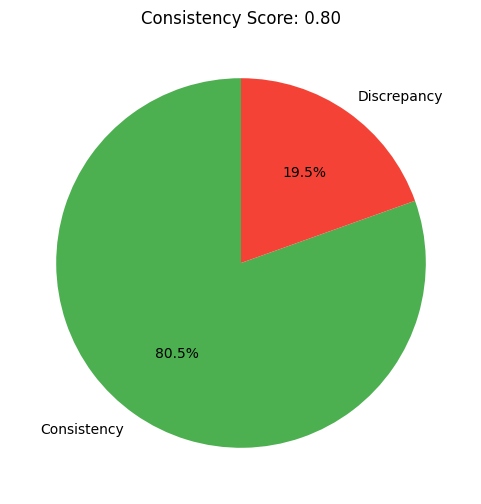

In [ ]:
# Sentiment scores from FinBERT defined above in average_finbert_sentiment, but need to normalize first
def normalize_sentiment(sentiment_scores):
    return {topic: (score + 1) / 2 for topic, score in sentiment_scores.items()}

sentiment_scores = normalize_sentiment(average_finbert_sentiment)

# Financial metric scores
financial_metric_scores = {0: 0.8013, 1: 0.6631, 2: 0.7354, 3: 0.4715, -1: 0.6703}

# Number of topics (N)
N = len(sentiment_scores)

# Calculate the consistency score using the formula
consistency_score = 1 - (1 / N) * sum(abs(sentiment_scores[i] - financial_metric_scores[i]) for i in sentiment_scores)

import matplotlib.pyplot as plt

# Function to generate a pie chart highlighting the sentiment_score % of the circle
def plot_consistency_pie_chart(consistency_score):
    # Data for the pie chart
    data = [consistency_score, 1 - consistency_score]

    # Labels and colors - change later
    labels = ['Consistency', 'Discrepancy']
    colors = ['#4CAF50', '#F44336']

    # Plot the pie chart
    plt.figure(figsize=(6,6))
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Consistency Score: {consistency_score:.2f}')
    plt.show()

# Call the function
plot_consistency_pie_chart(consistency_score)

### Next Step: Text to Data Mapping

The code above identifies broad themes such as M&A, drug approvals, cost-cutting, etc. but it doesn't map specific figures in the financials to specific sentences or paragraphs in the text. An ideal next step would be to have a more granular mapping so that we can do something like the following:

1.   MD&A clearly states that "our successful M&A practices supplement our organic growth, and we aim to continue this strategy" --- why then do footnotes show that has the company taken goodwill writedown in 3 of the past 6 quarters related to overzealous M&A?
2.   MD&A also states that "company continues its growth trajectory" when growth has slowed from double digits in each of the past 15 quarters to just 3% this year, well below historical norms and its competitors?

The code above CAN capture the financial implications with a low normalized financial metric score, but the general sentiment score would not specifically map to these sentences. The general focus of the sentiment analysis might pick up on this, but not at the level of granularity I'm thinking of now.

I'd like to think of a better way to map this out. Will need to think about this. Aspect-Based Sentiment Analysis is one approach.

### *Original Notes on Idea 1 - Sent Sept 2*

**These are the original notes I provided on the first idea. Just keeping here for consistency and refernce to make sure I don't forget anything. Most of this is addressed and what is outstanding has been noted.**


  
  Idea 1 - Comparing Text with Financial Figures of Same Document: Comparing the language used in the text of a financial document (such as the Management Discussion and Analysis) with the actual financial figures within the same document to see if they align.

o   Example: A company might state, "2023 represented another year of continued growth for all our divisions," when all five divisions had record low growth rates of 1-2% (barely positive). Alternatively, a more accurate statement might be, "2023 was a challenging year, in which we were able to maintain profitability, but growth was severely limited."

o   Method – Sentiment Analysis: Use sentiment analysis to determine whether the text is overly positive or negative (and whether it is hyperbolic or literal) and compare that sentiment to the financial figures.

o   Method – Topic Modeling + Named Entity Recognition: Use topic modeling to identify broad themes (such as growth, margins, M&A) and named entity recognition (NER) to find specific figures mentioned in the text, including key omissions or what is left unsaid.

o   Method – Text to Data Mapping: Develop a system where frequently used phrases or terms are mapped directly to specific financial metrics using a trained machine learning model. This system could produce a consistency score indicating how well the language used matches the financial data.

o   Quantitative vs. Qualitative Discrepancy Score: Create a single or a set of scores that represent how accurately and authentically the text reflects the company's financial health compared to the actual financial figures.

o   Considerations:

§  Use measurable quantities to support the score.

§  Balance between fewer summary statistics (to avoid oversimplification) and more granular data (to maintain credibility).

§  Finding the right balance is challenging, as too high-level could lack nuance, while too granular might reduce usability.